In [16]:
%matplotlib inline
import numpy as np
from glob import glob
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from venn import venn
from collections import Counter
from matplotlib.colors import DivergingNorm
import warnings

In [2]:
def load_data(v, nectar_clades, nonnectar_clades, data_type):
    dir_path = f'/Users/osipova/Documents/LabDocs/NectarivoryProject/absrel/absrel_analysis_2024/{v}/ClusterProfiler/'
    all_results = {}
    clades = nectar_clades + nonnectar_clades
    for clade in clades:
        file_name = get_file_name(clade, data_type)
        
        file_data = glob(dir_path + file_name)[0]
        df = pd.read_csv(file_data, sep='\t')
        all_results[clade] = df
    return all_results

In [3]:
def get_file_name(clade, data_type):
    if data_type == 'absrel':
        return f'hg38.goenrich.{clade}.under_selection_per_clade_0.05.tsv'
    elif data_type == 'RNAseq':
        direction = 'down' # Or any other logic to determine this
        return f'goenrich.hg38.{direction}.{clade}.multi_deseq2_res.tsv'
    return ''

In [4]:
def count_gos(all_results, clades):
    all_goids = []
    for clade in clades:
        all_goids.extend(all_results[clade][all_results[clade]['pvalue'] < 0.05]['ID'])
    return Counter(all_goids)

In [5]:
def filter_and_merge_go_data(all_results, target_clades, rank_target):
    data_filtered = {}
    for clade in target_clades:
        df_clade = all_results[clade]
        filt_df_clade = df_clade[df_clade['ID'].isin(rank_target)][['ID', 'Description', 'pvalue']]
        data_filtered[clade] = filt_df_clade
    
    merged_df = pd.DataFrame({'ID': [], 'Description': []})
    for clade, df in data_filtered.items():
        df[f'logP_{clade}'] = np.log10(df['pvalue'])
        df.drop('pvalue', axis=1, inplace=True)
        merged_df = pd.merge(merged_df, df, on=['ID', 'Description'], how='outer')
    
    merged_df.set_index('Description', inplace=True)
    return merged_df

In [14]:
def plot_heatmap(data, vmin):
    cmap_pval = sns.diverging_palette(285, 200, 100, as_cmap=True)
    divnorm_pval = DivergingNorm(vmin=vmin, vmax=0, vcenter=np.log10(0.051))
    pval_cols = [i for i in data.columns if i.startswith('logP_')]
    df_pval = data[pval_cols]

    fig, axes = plt.subplots(figsize=(1.8, len(data)/2.5))
    sns.heatmap(data=df_pval, cmap=cmap_pval, norm=divnorm_pval, ax=axes)
    axes.set_ylabel('')
    fig.tight_layout()

## 1. aBSREL GO enrichments

In [17]:
TARGET_OPTIONS = ['nectar', 'nonnectar']
TARGET = 'nectar'
# ANALYSIS = 'combined_default_srv_mh_v2'
# ANALYSIS = 'weighted_default_srv_mh/'
ANALYSIS = 'intersect_default_weighted'

### 1.1. Load GO enrichment tables

In [18]:
nectar_clades = ['hmmbrds', 'nectar_parrots', 'honeyeaters', 'sunbirds']
nonnectar_clades = ['swifts', 'falcons', 'lyrebirds', 'passerides']
all_results = load_data(ANALYSIS, nectar_clades, nonnectar_clades, 'absrel')

### 1.2. Rank Calculation

In [19]:
rank = 3

nectar_go_count = count_gos(all_results, nectar_clades)
rank_nectar_go = [k for k in nectar_go_count if nectar_go_count[k] >= rank]

rank = 2
nonnectar_go_count = count_gos(all_results, nonnectar_clades)
rank_nonnectar_go = [k for k in nonnectar_go_count if nonnectar_go_count[k] >= rank]

print(len(rank_nectar_go))
print(len(rank_nonnectar_go))

6
30


### 1.3. Select Target Data

In [20]:
target_clades = nectar_clades if TARGET == 'nectar' else nonnectar_clades
rank_target = rank_nectar_go if TARGET == 'nectar' else []

merged_df = filter_and_merge_go_data(all_results, target_clades, rank_target)

### 1.3.x. Exlude nonnectar with rank 2

In [23]:
# Exclude IDs
# EXCLUDE_NONNECTAR = ['GO:0043547', 'GO:0007272', 'GO:0008366', 'GO:0042552']
EXCLUDE_NONNECTAR = rank_nonnectar_go
# EXCLUDE_CHILDREN = ["GO:0008366", "GO:0042552", "GO:0071805", "GO:0097623"]
# EXCLUDE_CHILDREN = ['GO:0042552', 'GO:0008366']
EXCLUDE_CHILDREN = ['GO:0031295', 'GO:0043547', 'GO:0090630']

EXCLUDE_IDS = EXCLUDE_NONNECTAR + EXCLUDE_CHILDREN

merged_df = merged_df[~merged_df['ID'].isin(EXCLUDE_IDS)]

### 1.4. Plot Heatmap

/Users/osipova/local/Homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/osipova/local/Homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  # Remove the CWD from sys.path while we load stuff.


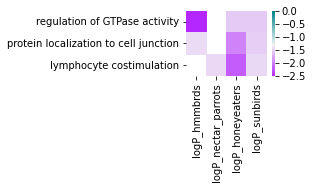

In [24]:
plot_heatmap(merged_df, vmin=-2.5)

# Save to PDF
pdf_name = 'clusterProfiler.absrel_2024_results.nectar.pdf'
# plt.savefig(pdf_name, bbox_inches='tight')

In [102]:
merged_df.to_csv('3_4_way_convergent_terms.nectar.tsv', sep='\t')

## 2. RNAseq GO enrichemnt

In [96]:
def load_rnaseq_data(dir_path, clades, directions, tissues, pref, suff):
    all_results = {}
    for d in directions:
        for clade in clades:
            for t in tissues:
                file_name = f'{pref}.{d}.{clade}.{t}.{suff}'.replace('..', '.')
                file_data = glob(dir_path + file_name)[0]
                df = pd.read_csv(file_data, sep='\t')
                all_results[(d, clade, t)] = df
    return all_results

In [31]:
def count_gos(all_results, clades, d, t, PVAL, P):
    all_goids = []
    for clade in clades:
        all_goids.extend(all_results[(d, clade, t)][all_results[(d, clade, t)][PVAL] < P]['ID'])
    return Counter(all_goids)

In [46]:
def filter_and_merge_clade_data(all_results, clades, rank_list, d, t, PVAL, P):
    data_rank = {}
    for clade in clades:
        df_clade = all_results[(d, clade, t)]
        filt_df_clade = df_clade[df_clade['ID'].isin(rank_list)][['ID', 'Description', PVAL]]
        
        ## Add P-adj filter
        filt_df_clade = filt_df_clade[filt_df_clade[PVAL] <= P]
        data_rank[clade] = filt_df_clade

    merged_df = pd.DataFrame({'ID': [], 'Description': []})
    for clade, df in data_rank.items():
        df[f'logP_{clade}'] = np.log10(df[PVAL])
        df.drop(PVAL, axis=1, inplace=True)
        if not(df.empty):
            merged_df = pd.merge(merged_df, df, on=['ID', 'Description'], how='outer')
    merged_df.set_index('Description', inplace=True)
    return merged_df

In [77]:
def plot_rnaseq_heatmap(df, P):
    cmap_pval = sns.diverging_palette(285, 200, 100, as_cmap=True)
    divnorm_pval = DivergingNorm(vmin=-5, vmax=0, vcenter=np.log10(P+0.001))
    pval_cols = [col for col in df.columns if col.startswith('logP_')]
    df_pval = df[pval_cols]

    fig, ax = plt.subplots(figsize=(2.2, len(df)/2.3))
    sns.heatmap(data=df_pval, cmap=cmap_pval, norm=divnorm_pval, ax=ax)
    ax.set_ylabel('')
    fig.tight_layout()

### 2.1. Load GO enrichment tables

In [91]:
RNA_DIR_PATH = '/Users/osipova/Documents/LabDocs/Bird_transcriptomics/Transcriptome_for_NectarGenomics/DESeq2_results_Kallisto/ClusterProfiler/'
NECTAR_CLADES = ['Annas_hummingbird', 'New_Holland_honeyeater', 'rainbow_lorikeet']
DIRECTIONS = ['up', 'down']
TISSUES = ['pectoralis', 'liver', 'heart', 'duodenum', 'palate']
RANK = 2
PVAL = 'p.adjust'
P = 0.2

PREF = 'hg38.goenrich'
SUFF = 'top_0.05.tsv'

all_results = load_rnaseq_data(RNA_DIR_PATH, NECTAR_CLADES, DIRECTIONS, TISSUES, PREF, SUFF)

### 2.2. Analyze and plot heatmaps

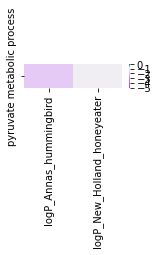

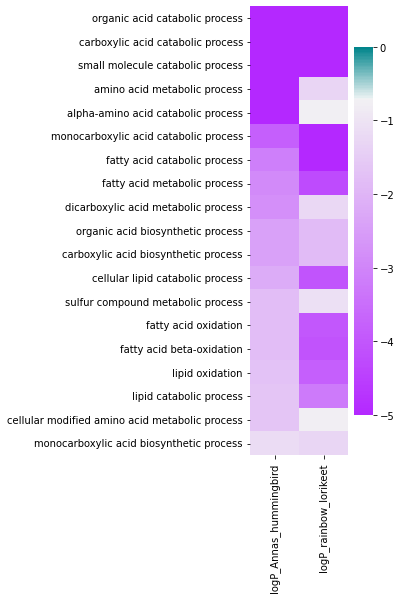

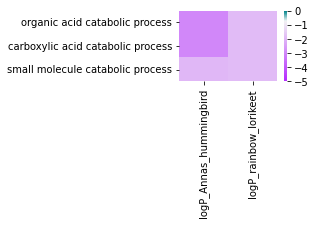

In [92]:
warnings.filterwarnings('ignore')

all_merged_dfs = {}

for d in DIRECTIONS:
    for t in TISSUES:
        nectar_go_count = count_gos(all_results, NECTAR_CLADES, d, t, PVAL, P)
        rank_nectar_go = [k for k in nectar_go_count if nectar_go_count[k] == RANK]
       
        all_merged_dfs[(d, t)] = filter_and_merge_clade_data(all_results, 
                                                             NECTAR_CLADES, 
                                                             rank_nectar_go, 
                                                             d, 
                                                             t, 
                                                             PVAL,
                                                             P)
        ## write to file
        merged_df_path = f'{RNA_DIR_PATH}/rank{RANK}.goenrich.{d}.all_nectar.{t}.top_0.05.tsv'
        all_merged_dfs[(d, t)].to_csv(merged_df_path, sep='\t')

        ## plot heatmap
        if not merged_df.empty:
            plot_rnaseq_heatmap(merged_df, P)

## Exclude children (outside) and plot heatmaps

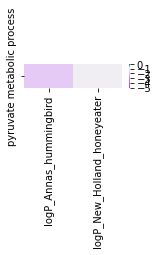

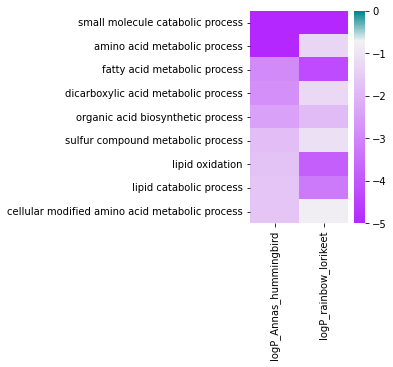

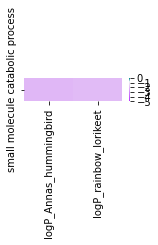

In [89]:
RNA_DIR_PATH = '/Users/osipova/Documents/LabDocs/Bird_transcriptomics/Transcriptome_for_NectarGenomics/DESeq2_results_Kallisto/ClusterProfiler/'
DIRECTIONS = ['up', 'down']
TISSUES = ['pectoralis', 'liver', 'heart', 'duodenum', 'palate']
RANK = 2
PVAL = 'p.adjust'
P = 0.2

for d in DIRECTIONS:
    for t in TISSUES:

        file_name = f'{RNA_DIR_PATH}/noChildren.rank{RANK}.goenrich.{d}.all_nectar.{t}.top_0.05.tsv'
        file_data = glob(file_name)[0]
        df = pd.read_csv(file_data, sep='\t')
        df = df.set_index('Description')
        if not df.empty:
            plot_rnaseq_heatmap(df, P)

            ## Save plot
            pdf_name = f'{RNA_DIR_PATH}/rank{RANK}.goenrich.multi_deseq2.nectar.{d}_{t}.pdf'
            plt.savefig(pdf_name, format='pdf', bbox_inches='tight')

## Multifactor DESeq2 Enrichments

In [108]:
RNA_DIR_PATH = '/Users/osipova/Documents/LabDocs/Bird_transcriptomics/Transcriptome_for_NectarGenomics/Multifactor_DESeq2_results/ClusterProfiler/'
NECTAR_CLADES = ['Annas_hummingbird', 'New_Holland_honeyeater', 'rainbow_lorikeet']
DIRECTIONS = ['up', 'down']
TISSUES = ['']

RANK = 2
PVAL = 'p.adjust'
P = 0.3

PREF = 'goenrich.hg38'
SUFF = 'multi_deseq2_res.tsv'

all_results = load_rnaseq_data(RNA_DIR_PATH, NECTAR_CLADES, DIRECTIONS, TISSUES, PREF, SUFF)

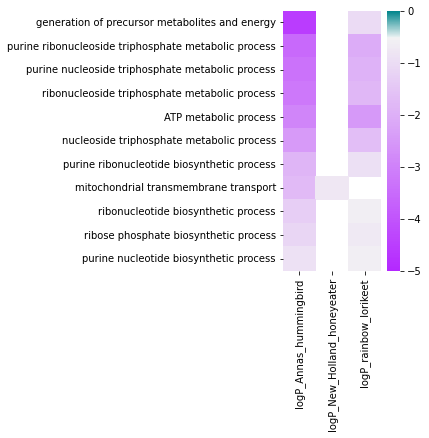

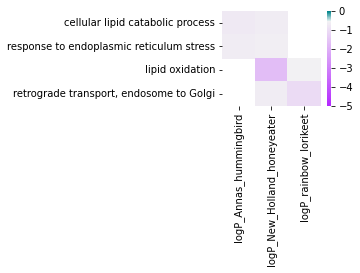

In [113]:
warnings.filterwarnings('ignore')

for d in DIRECTIONS:
    for t in TISSUES:
        nectar_go_count = count_gos(all_results, NECTAR_CLADES, d, t, PVAL, P)
        rank_nectar_go = [k for k in nectar_go_count if nectar_go_count[k] == RANK]
       
        all_merged_dfs[(d, t)] = filter_and_merge_clade_data(all_results, 
                                                             NECTAR_CLADES, 
                                                             rank_nectar_go, 
                                                             d, 
                                                             t, 
                                                             PVAL,
                                                             P)
        ## write to file
        merged_df_path = f'{RNA_DIR_PATH}/rank{RANK}.goenrich.{d}.all_nectar.{t}.top_0.05.tsv'
        all_merged_dfs[(d, t)].to_csv(merged_df_path, sep='\t')
        plot_rnaseq_heatmap(all_merged_dfs[(d, t)], P)

## 3. Breakdown selected terms in aBSREL GO enrichemnts

In [60]:
def load_process_and_plot_cp_data(dbs, dir_path, p_cutoff, count_cutoff):
    DF_dbs = {}
    nonzero_dbs = []

    # Load and process the data
    for db in dbs:
        file_name = f'noChildren.gt2genes.hg38.goenrich.{db}.nectar.tsv'
        file_data = glob(dir_path + file_name)[0]
        df = pd.read_csv(file_data, sep='\t')
        df = df[(df['p.adjust'] < p_cutoff) & (df['Count'] >= count_cutoff)]

        if not df.empty:
            df['GOfull'] = df['Description']
            df['logpval'] = np.log10(df['pvalue'])
            DF_dbs[db] = df
            nonzero_dbs.append(db)

    # Plot the bar plots
    if nonzero_dbs:  # Only plot if there are non-zero databases
        fig, axes = plt.subplots(len(nonzero_dbs), 1, gridspec_kw={'height_ratios': [DF_dbs[db].shape[0] for db in nonzero_dbs]}, 
                                 figsize=(1, 8*len(nonzero_dbs)))
        cmap_pval = sns.diverging_palette(285, 200, 100, as_cmap=True)
        divnorm_pval = DivergingNorm(vmin=-2.5, vmax=0, vcenter=np.log10(0.051))

        for i, db in enumerate(nonzero_dbs):
            try:
                ax = axes[i]
            except TypeError:
                ax = axes

            dfi = DF_dbs[db]
            dfi.set_index('GOfull', inplace=True)

            sns.heatmap(ax=ax, data=dfi[['logpval']], cmap=cmap_pval, norm=divnorm_pval)
            ax.set_title(f'{db}')
            ax.set_ylabel('')
            ax.set_xlabel('')
            ax.legend([], [], frameon=False)
        
        sns.despine()
        fig.subplots_adjust(bottom=0, top=0.6, wspace=0, hspace=0.6)
        fig.tight_layout()

        # Save the plot
        pdf_name = f'noChildren.hg38.goenrich.{db}.nectar.pdf'
        fig.savefig(dir_path + pdf_name, bbox_inches='tight')
    return 

### 3.1. Plot breakdown 

/Users/osipova/local/Homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
/Users/osipova/local/Homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


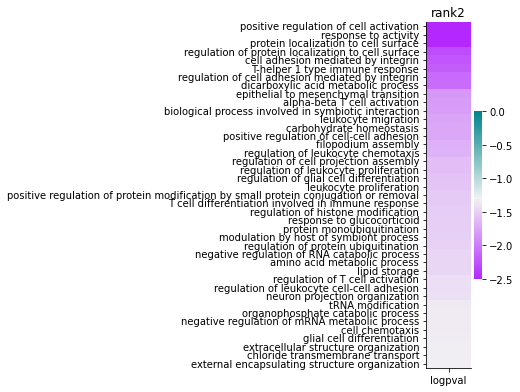

In [64]:
# ANALYSIS = 'intersect_default_weighted'
ANALYSIS = 'weighted_default_srv_mh/'
ABSREL_DIR_PATH = f'/Users/osipova/Documents/LabDocs/NectarivoryProject/absrel/absrel_analysis_2024/{ANALYSIS}/ClusterProfiler/'

DBS = ['rank2']
load_process_and_plot_cp_data(DBS, ABSREL_DIR_PATH, p_cutoff=1, count_cutoff=3)

### 3.2. Plot representative GO

/Users/osipova/local/Homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
/Users/osipova/local/Homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


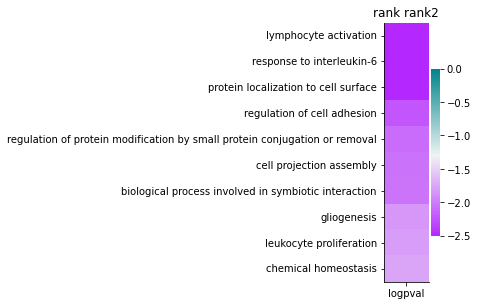

In [69]:
# ANALYSIS = 'combined_default_srv_mh_v2'
# ANALYSIS = 'intersect_default_weighted'
ANALYSIS = 'weighted_default_srv_mh/'

dir_path = f'/Users/osipova/Documents/LabDocs/NectarivoryProject/absrel/absrel_analysis_2024/{ANALYSIS}/ClusterProfiler/'
# dbs = ['rank1', 'rank2', 'rank3', 'rank4']
dbs = ['rank2']
target = 'nectar'
DF_dbs = {}
nonzero_dbs = []


for db in dbs:
    file_name = f'represent_GO.hg38.goenrich.{db}.{target}.tsv'    
    file_data = glob(dir_path + file_name)[0]
    df = pd.read_csv(file_data, sep='\t')

    if not df.empty:
        df['GOfull'] = df['TERM']
        df['logpval'] = np.log10(df['minpval'])
        DF_dbs[db] = df
        nonzero_dbs.append(db)

fig, axes = plt.subplots(len(nonzero_dbs), 1, gridspec_kw={'height_ratios': [DF_dbs[db].shape[0] for db in nonzero_dbs]}, 
                         figsize=(1, 6*len(nonzero_dbs)))

cmap_pval = sns.diverging_palette(285, 200, 100, as_cmap=True)
divnorm_pval = DivergingNorm(vmin=-2.5, vmax=0, vcenter=np.log10(0.051))

for i, db in enumerate(nonzero_dbs):
    try:
        ax = axes[i]
    except TypeError:
        ax = axes
    dfi = DF_dbs[db]
    dfi.set_index('GOfull', inplace=True)

    sns.heatmap(ax=ax, data=dfi[['logpval']], cmap=cmap_pval, norm=divnorm_pval)
    ax.set_title(f'rank {db}')
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.legend([], [], frameon=False)


sns.despine()
fig.subplots_adjust(bottom=0, top=0.6, wspace=0, hspace=0.6)
fig.tight_layout()
pdf_name = 'represent_GO.hg38.goenrich.all_ranks.nectar.pdf'
# fig.savefig(dir_path + pdf_name, bbox_inches='tight')
